## Tutorial 2: Training segmentation model for 2018 Data Science Bowl dataset.

### Introduction

This is a quick walkthrough notebook to demonstrate how to train U-Net segmentation model on Data Science Bowl 18 Dataset using PyTorch! At the end of this tutorial, you are expected to get `bestmodel.pt` file inside `model` folder.

### Table of contents

- [Imports](#imports)
- [Load Data Science Bowl 18 Dataset](#load-data-science-bowl-18-dataset)
- [Define dataloaders](#define-dataloaders)
- [Define loss](#define-loss)
- [Load model](#load-model)
- [Start training loop](#start-training-loop)

#### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from skimage import io, transform
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import shutil
from farabio.models.segmentation import *
from farabio.data.biodatasets import *

#### Load Data Science Bowl 18 Dataset

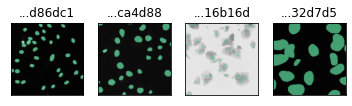

In [2]:
_path = "/home/data/07_SSD4TB/public-datasets/data-science-bowl-2018/"

train_dataset = DSB18Dataset(_path, transform=None, download=False, mode="train", show=True)
valid_dataset = DSB18Dataset(_path, transform=None, download=False, mode="val", show=False)

#### Define dataloaders

In [3]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=8)

#### Define loss

In [4]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)        #???????
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

#### Load model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = unet_resnet34(in_channels=3, out_channels=1).to(device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
print("model is ready!")

Let's use 4 GPUs!
model is ready!


#### Start training loop

In [6]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [8]:
if not os.path.exists("model"):
    os.makedirs("model")
    
#from engine import evaluate
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs = 1
valid_loss_min = np.Inf

checkpoint_path = 'model/chkpoint_'
best_model_path = 'model/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    #<-----------Training Loop---------------------------->
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train,fname in pbar:
        x_train = torch.autograd.Variable(x_train).to(device)
        y_train = torch.autograd.Variable(y_train).to(device)
        optimizer.zero_grad()
        output = model(x_train)
        #Loss
        loss = criterion(output, y_train)
        losses_value = loss.item()
        #Score
        score = accuracy_metric(output,y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(losses_value)
        train_score.append(score.item())
        #train_score.append(score)
        pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")

    #<---------------Validation Loop---------------------->
    with torch.no_grad():
        for image,mask,fname in valid_loader:
            image = torch.autograd.Variable(image).to(device)
            mask = torch.autograd.Variable(mask).to(device)
            output = model(image)
            ## Compute Loss Value.
            loss = criterion(output, mask)
            losses_value = loss.item()
            ## Compute Accuracy Score
            score = accuracy_metric(output,mask)
            valid_loss.append(losses_value)
            valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
    print(f"###############Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")

    #Save best model Checkpoint
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    ## TODO: save the model if validation loss has decreased
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]

Epoch: 1, loss: 0.23099388050187286, IoU: 0.6247038565451642: 100%|█████████████████████| 34/34 [03:47<00:00,  6.69s/it]



###############Train Loss: 0.362613257634677, Train IOU: 0.47284613069054704###############
###############Valid Loss: 0.38213493389016623, Valid IOU: 0.4533167557518091###############
Validation loss decreased (inf --> 0.382135).  Saving model ...
